## Example Argo float programming
### In the Tropical Atlantic
In this tutorial you will simulate the temperature and salinity profiles of an Argo float using the Parcels toolbox.

In [ ]:
from parcels import (
    FieldSet,
    ParticleSet,
    JITParticle,
    Variable,
    AdvectionRK4,
    ScipyParticle,
    StatusCode,
)
import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
from datetime import timedelta
import cmocean

For the simulation, you will need to download a NetCDF file with the hydrodynamic (velocities, temperature, salinity) data. We use data from the Copernicus Marine Environmental Monitoring Service (CMEMS) [Global Ocean 1/12° Physics Analysis and Forecast product](https://resources.marine.copernicus.eu/product-detail/GLOBAL_ANALYSIS_FORECAST_PHY_001_024/INFORMATION). For this assignment, we've compiled all the flow data you need into one file (~120MB), which you can find [here](https://surfdrive.surf.nl/files/index.php/s/Sn5KFlFAS10Hxbt/download).

In [ ]:
# Download data
import requests

files = {
    "global-analysis-forecast-phy-001-024_1641284158025.nc": "https://surfdrive.surf.nl/files/index.php/s/Sn5KFlFAS10Hxbt/download"
}

for filename, url in files.items():
    response = requests.get(url, allow_redirects=True)

    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)
    else:
        print("Failed to download", url)
print("Download ready")

In [ ]:
# Execute the code below to create what's in Parcels called a `FieldSet` object
filename = "global-analysis-forecast-phy-001-024_1641284158025.nc"
variables = {
    "U": "uo",  # dictionary with names of the variables in the netcdf file
    "V": "vo",
    "S": "so",
    "T": "thetao",
}
dimensions = {
    "lon": "longitude",  # dictionary with names of the dimensions in the netcdf file
    "lat": "latitude",
    "depth": "depth",
    "time": "time",
}

fieldset = FieldSet.from_netcdf(filename, variables, dimensions)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

You can plot the two components of the flow field (at the surface) with the following code.

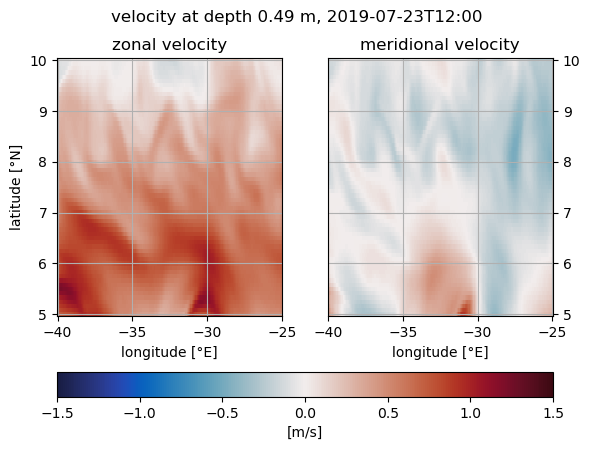

The dimensions of the data are:
lon: 181
lat: 61
depth: 41
time: 34 (2 loaded)


In [ ]:
fieldset.computeTimeChunk()  # first load the data in memory

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
p0 = ax[0].pcolormesh(
    fieldset.U.lon,
    fieldset.U.lat,
    fieldset.U.data[0, 0, :, :],
    vmin=-1.5,
    vmax=1.5,
    cmap=cmocean.cm.balance,
)
p1 = ax[1].pcolormesh(
    fieldset.V.lon,
    fieldset.V.lat,
    fieldset.V.data[0, 0, :, :],
    vmin=-1.5,
    vmax=1.5,
    cmap=cmocean.cm.balance,
)
ax[0].set_title("zonal velocity")
ax[1].set_title("meridional velocity")
ax[0].set_ylabel("latitude [°N]")
ax[0].set_xlabel("longitude [°E]")
ax[1].set_xlabel("longitude [°E]")
ax[1].yaxis.set_tick_params(left=False, right=True, labelleft=False, labelright=True)
ax[0].grid()
ax[1].grid()
cb = fig.colorbar(p1, ax=ax, orientation="horizontal")
cb.set_label("[m/s]")
gd = fieldset.U.grid
fig.suptitle(
    f"velocity at depth {gd.depth[0]:.2f} m, {gd.timeslices[0][0].astype('datetime64[m]')}"
)
plt.show()

print(
    f"The dimensions of the data are:\nlon: {gd.xdim}\nlat: {gd.ydim}\ndepth: {gd.zdim}\ntime: {len(gd.time_full)} ({gd.tdim} loaded)"
)

Parcels uses the oceanic data in `fieldset` to represent the environment of a 'particle'. Particles are objects that by default hold information on there position and time. The behaviour of particles is determined by a kernel. A commonly used kernel is `AdvectionRK4`, which prescribes advection using a 4th order Runge-Kutta numerical scheme. The `fieldset` data is interpolated to the particle position and time, then the particle gets advected to determine velocities at the new position. This process is repeated three times in a clever way to minimize the numerical error.

A few years ago, [Mike Hart-Davis](https://www.dgfi.tum.de/en/staff/hart-davis-michael/) wrote a `Kernel` for Parcels to easily simulate the behaviour of an Argo float. That code, which is also available in [this notebook tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_Argofloats.html), is copied in the cell below. Go through it and make sure you understand what it does. For practical purposes, you may assume `particle.depth` and `particle_ddepth` both represent the particle depth.


In [ ]:
# Define the new Kernel that mimics Argo vertical movement
def ArgoVerticalMovement(particle, fieldset, time):
    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.10  # sink and rise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 9 * 86400  # time of deep drift in seconds

    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle_ddepth += vertical_speed * particle.dt
        if particle.depth >= driftdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle_ddepth += vertical_speed * particle.dt
        if particle.depth >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle_ddepth -= vertical_speed * particle.dt
        particle.cycle_age += (
            particle.dt
        )  # solve issue of not updating cycle_age during ascent
        if particle.depth <= fieldset.mindepth:
            particle.depth = fieldset.mindepth
            particle.temp = (
                math.nan
            )  # reset temperature to NaN at end of sampling cycle
            particle.salt = math.nan  # idem
            particle.cycle_phase = 4
        else:
            particle.temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]
            particle.salt = fieldset.S[time, particle.depth, particle.lat, particle.lon]

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    if particle.state == StatusCode.Evaluate:
        particle.cycle_age += particle.dt  # update cycle_age


def KeepAtSurface(particle, fieldset, time):
    # Prevent error when float reaches surface
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = fieldset.mindepth
        particle.state = StatusCode.Success

Before we can run this code, we also need to define a new Particle class, that has extra Variables like `cycle_phase`, `cycle_age` etc needed by the `ArgoVerticalMovement()` Kernel.  
*Note that if you get a compiler error here, you could try to swap the `JITParticle` in the `ArgoParticle` class definition for `ScipyParticle`.*

In [ ]:
# Define the ArgoParticle class
variables = [
    Variable("cycle_phase", dtype=np.int32, initial=0.0),
    Variable("cycle_age", dtype=np.float32, initial=0.0),
    Variable("drift_age", dtype=np.float32, initial=0.0),
    Variable("temp", dtype=np.float32, initial=np.nan),
    Variable("salt", dtype=np.float32, initial=np.nan),
]
ArgoParticle = JITParticle.add_variables(variables)

Now we can create a `ParticleSet`, which in this case consists of one `ArgoParticle`. We have to specify its initial position and time. Note that you could add any number of Argo floats here, all having different starting positions. We will simply use one float, however.

In [ ]:
# Define the ParticleSet
argoset = ParticleSet(
    fieldset=fieldset,
    pclass=ArgoParticle,
    lon=[-37.09499],
    lat=[6.73472],
    depth=fieldset.mindepth,
    time=np.datetime64("2019-07-25T11:14:00"),
)

If we then combine the `ArgoVerticalMovement()` kernel with the built-in `AdvectionRK4()` (for the horizontal movement) and the `KeepAtSurface()` (for ending the ascent), we can compute the trajectory. This may take a while.  

*Note that `particle_ddepth` is a copy of `particle.depth` inside `ArgoVerticalMovement()`. On every time step, `particle.depth` is kept constant until all kernels have been executed. Only then are the depth changes in every kernel, `particle_ddepth - paricle.depth`, summed together to find the new depth. Therefore, the outcome does not depend on the ordering of the kernels.*

In [ ]:
argoset.execute(
    [
        ArgoVerticalMovement,
        AdvectionRK4,
        KeepAtSurface,
    ],  # list of kernels to be executed
    runtime=timedelta(days=31),
    dt=timedelta(minutes=5),
    output_file=argoset.ParticleFile(
        name="argo_float", outputdt=timedelta(minutes=5), chunks=(1, 500)
    ),
)

You can open the dataset and view the Argo trajectory with this sample code.

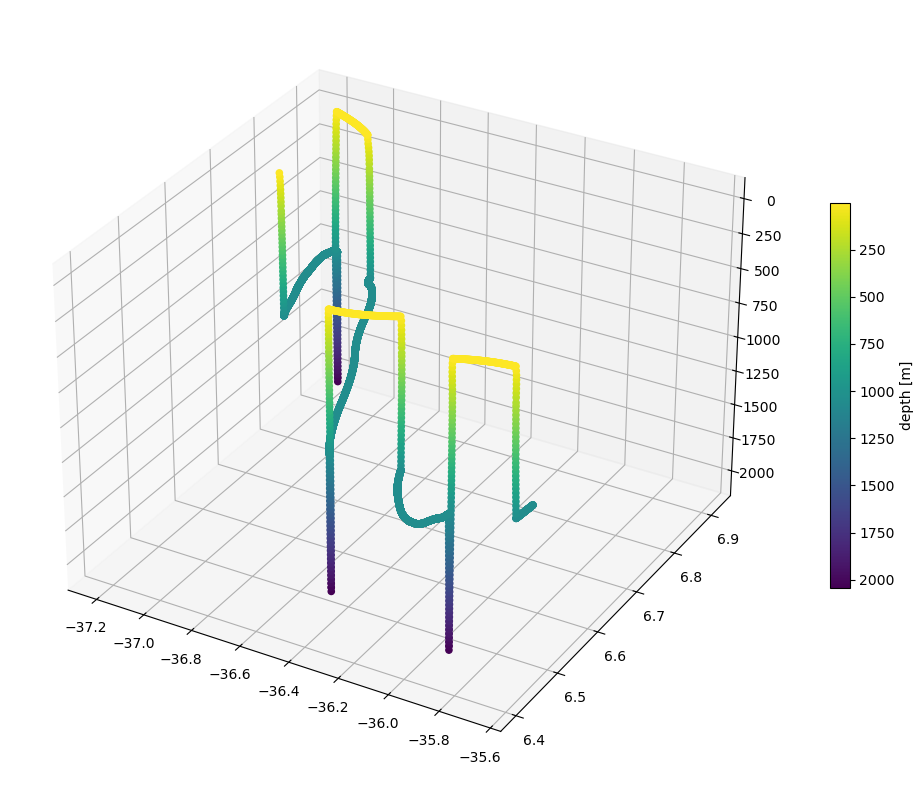

In [ ]:
# Plot the trajectory of the Argo float you've just simulated
ds_argo = xr.open_zarr("argo_float.zarr")

x = ds_argo["lon"][:].squeeze()
y = ds_argo["lat"][:].squeeze()
z = ds_argo["z"][:].squeeze()

fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
ax.invert_zaxis()
p = ax.scatter(x, y, z, c=z, s=20, marker="o", cmap="viridis_r", depthshade=False)
cb = plt.colorbar(p, shrink=0.5)
cb.ax.invert_yaxis()
cb.set_label("depth [m]")

Here's an example that makes the ascent twice as slow without changing the sink velocity and stores your data in a different file. You need to define the `argoset` again, because by default the simulation will otherwise continue where the previous run ended. To speed up the simulation you can set the `outputdt` to 30 minutes.

INFO: Output files are stored in argo_float2.zarr.
100%|██████████████████████████████████████████████████████████████████| 2678400.0/2678400.0 [00:38<00:00, 68785.46it/s]


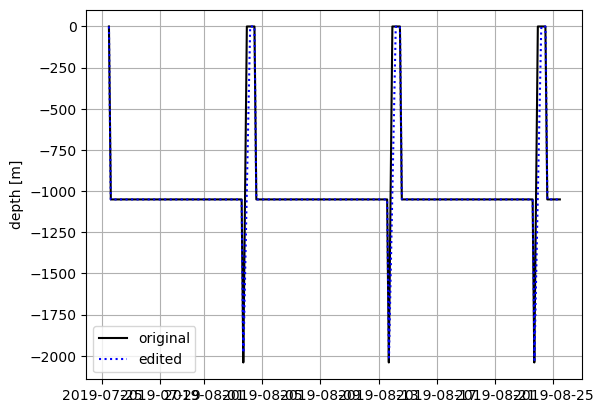

In [ ]:
# Answer


def ArgoVerticalMovement2(particle, fieldset, time):  # -- change kernel name
    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.10  # sink and rise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 9 * 86400  # time of deep drift in seconds

    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle_ddepth += vertical_speed * particle.dt
        if particle.depth >= driftdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle_ddepth += vertical_speed * particle.dt
        if particle.depth >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle_ddepth -= (
            vertical_speed * particle.dt / 2.0
        )  # ------------- make twice as slow
        particle.cycle_age += particle.dt
        particle.temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]
        particle.salt = fieldset.S[time, particle.depth, particle.lat, particle.lon]
        if particle.depth <= fieldset.mindepth:
            particle.depth = fieldset.mindepth
            particle.temp = (
                math.nan
            )  # reset temperature to NaN at end of sampling cycle
            particle.salt = math.nan  # idem
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    if particle.state == StatusCode.Evaluate:
        particle.cycle_age += particle.dt  # update cycle_age


def KeepAtSurface(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = fieldset.mindepth
        particle.state = StatusCode.Success


argoset = ParticleSet(  # ------------ redefine argoset, otherwise simulation continues from previous run
    fieldset=fieldset,
    pclass=ArgoParticle,
    lon=[-37.09499],
    lat=[6.73472],
    depth=fieldset.mindepth,
    time=np.datetime64("2019-07-25T11:14:00"),
)
argoset.execute(
    [ArgoVerticalMovement2, AdvectionRK4, KeepAtSurface],  # ----- changed kernel
    runtime=timedelta(days=31),
    dt=timedelta(minutes=5),
    output_file=argoset.ParticleFile(
        name="argo_float2", outputdt=timedelta(minutes=30), chunks=(1, 500)
    ),  # -- changed filename
)

# Plot depth as a function of time for both the regular and slowly-ascending floats to check if your code works
ds_argo2 = xr.open_zarr("argo_float2.zarr")
fig = plt.figure()
plt.plot(ds_argo.time[0, :], -ds_argo.z[0, :], "k", label="original")
plt.plot(ds_argo2.time[0, :], -ds_argo2.z[0, :], "b:", label="edited")
plt.legend()
plt.grid()
plt.ylabel("depth [m]")
plt.show()

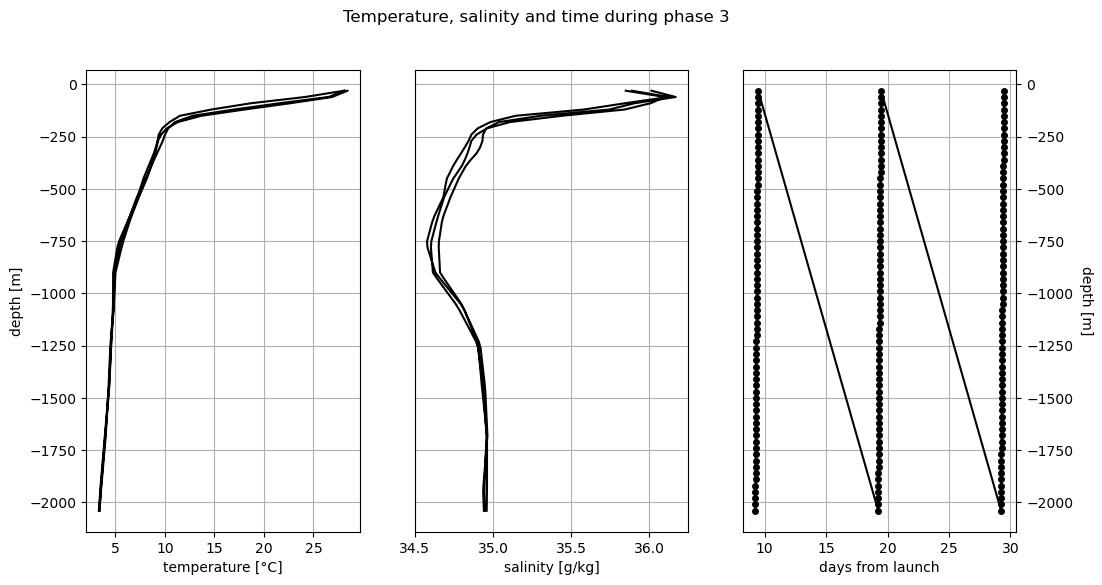

In [ ]:
# Plots of the vertical temperature and salinity profile, which were recorded during the ascents to the surface.
fig = plt.figure(figsize=(12, 6))
fig.suptitle(f"Temperature, salinity and time during phase 3")

days = (ds_argo.time[0, :] - ds_argo.time[0, 0]).data.astype("timedelta64[m]").astype(
    "int"
) / 1440
tids3 = (
    ~ds_argo.temp[0, :].isnull().compute()
)  # time indices during cycle phase 3 (ascent)

ax1 = fig.add_subplot(131)
ax1.plot(ds_argo.temp[0, :], -ds_argo.z[0, :], "k")
ax1.grid()
ax1.set_xlabel("temperature [°C]")
ax1.set_ylabel("depth [m]")

ax2 = fig.add_subplot(132, sharey=ax1)
ax2.plot(ds_argo.salt[0, :], -ds_argo.z[0, :], "k")
ax2.grid()
ax2.yaxis.set_tick_params(left=False, labelleft=False)
ax2.set_xlabel("salinity [g/kg]")

ax3 = fig.add_subplot(133, sharey=ax1)
ax3.plot(days[tids3], -ds_argo.z[0, tids3], "k-o", ms=4)
ax3.yaxis.tick_right()
ax3.yaxis.label_position = "right"
ax3.grid()
ax3.set_xlabel("days from launch")
ax3.set_ylabel("depth [m]", rotation=270)
plt.show()